# Imports basicos

In [1]:
# Celda 1: imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Para que los gráficos se vean dentro del notebook
%matplotlib inline

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")


# Cargar los datos del servidor y del cliente

In [2]:
# Ajusta las rutas si es necesario
df_server = pd.read_csv("file/tiempos_servicio.csv")
df_client = pd.read_csv("file/datos_cliente.csv")

print("Primeras filas - SERVER:")
display(df_server.head())

print("\nPrimeras filas - CLIENTE:")
display(df_client.head())


Primeras filas - SERVER:


,timestamp_llegada,timestamp_inicio_servicio,tiempo_servicio,timestamp_salida,tiempo_en_sistema,tiempo_espera_cola
0,"1,764,360,849.9281","1,764,360,849.9281",0.0656,"1,764,360,849.9945",0.0663,0.0000
1,"1,764,360,850.1916","1,764,360,850.1916",0.1112,"1,764,360,850.3029",0.1113,0.0000
2,"1,764,360,851.3777","1,764,360,851.3777",0.6378,"1,764,360,852.0158",0.6381,0.0000
3,"1,764,360,852.2654","1,764,360,852.2654",0.1390,"1,764,360,852.4054",0.1400,0.0000
4,"1,764,360,857.0602","1,764,360,857.0602",2.8227,"1,764,360,859.8843",2.8240,0.0000



Primeras filas - CLIENTE:


,id,interarrival,t_envio,t_respuesta,status_code,error
0,1,0.1076,"1,764,360,849.8980",0.0980,200,NaN
1,2,0.1824,"1,764,360,850.1794",0.1254,200,NaN
2,3,1.0459,"1,764,360,851.3515",0.6654,200,NaN
3,4,0.2279,"1,764,360,852.2458",0.1611,200,NaN
4,5,4.6293,"1,764,360,857.0371",2.8524,200,NaN


# Estadisticas descriptivos rapidos

In [4]:
print("Descriptivos SERVER:")
display(df_server[["tiempo_servicio", "tiempo_en_sistema", "tiempo_espera_cola"]].describe())

print("\nDescriptivos CLIENTE:")
display(df_client[["interarrival", "t_respuesta"]].describe())


Descriptivos SERVER:


,tiempo_servicio,tiempo_en_sistema,tiempo_espera_cola
count,50.0000,50.0000,50.0000
mean,0.9563,0.9571,0.0000
std,0.8541,0.8542,0.0000
min,0.0020,0.0030,0.0000
25%,0.2538,0.2548,0.0000
50%,0.6684,0.6692,0.0000
75%,1.3927,1.3936,0.0000
max,2.9522,2.9533,0.0000



Descriptivos CLIENTE:


,interarrival,t_respuesta
count,50.0000,50.0000
mean,1.5684,0.9760
std,1.4008,0.8554
min,0.0033,0.0265
25%,0.4162,0.2724
50%,1.0962,0.6841
75%,2.2840,1.4161
max,4.8416,2.9778


# Estimar λ (tasa de llegada) usando el servidor

In [5]:
# Ordenamos por llegada por si acaso
df_server_sorted = df_server.sort_values("timestamp_llegada").reset_index(drop=True)

# Diferencias entre llegadas consecutivas
llegadas = df_server_sorted["timestamp_llegada"].values
interarrivals_server = np.diff(llegadas)  # t_i - t_{i-1}

interarrival_prom_server = interarrivals_server.mean()
lambda_hat_server = 1.0 / interarrival_prom_server

print(f"Interarrival promedio (SERVER) ≈ {interarrival_prom_server:.4f} s")
print(f"λ_hat (SERVER) ≈ {lambda_hat_server:.4f} clientes/seg")


Interarrival promedio (SERVER) ≈ 2.5894 s
λ_hat (SERVER) ≈ 0.3862 clientes/seg


# Estimar λ usando los datos del cliente

In [7]:
# Celda 5: estimar lambda (λ) desde los interarrivals del CLIENTE

interarrival_prom_client = df_client["interarrival"].mean()
lambda_hat_client = 1.0 / interarrival_prom_client

print(f"Interarrival promedio (CLIENTE) ≈ {interarrival_prom_client:.4f} s")
print(f"λ_hat (CLIENTE) ≈ {lambda_hat_client:.4f} clientes/seg")


Interarrival promedio (CLIENTE) ≈ 1.5684 s
λ_hat (CLIENTE) ≈ 0.6376 clientes/seg


# Estimar μ (tasa de servicio) usando el servidor

In [9]:
servicio_prom = df_server["tiempo_servicio"].mean()
mu_hat = 1.0 / servicio_prom

print(f"Tiempo de servicio promedio ≈ {servicio_prom:.4f} s")
print(f"μ_hat ≈ {mu_hat:.4f} clientes/seg")


Tiempo de servicio promedio ≈ 0.9563 s
μ_hat ≈ 1.0456 clientes/seg


# Calcular ρ y métricas empíricas Wq, W (SERVER)

In [10]:
lambda_hat = lambda_hat_server   # puedes elegir lambda_hat_client s+
mu = mu_hat

rho_hat = lambda_hat / mu

Wq_emp = df_server["tiempo_espera_cola"].mean()
W_emp  = df_server["tiempo_en_sistema"].mean()

print(f"ρ_hat = λ_hat / μ_hat ≈ {rho_hat:.4f}")
print(f"Wq_emp (espera media en cola, SERVER) ≈ {Wq_emp:.4f} s")
print(f"W_emp  (tiempo medio en sistema, SERVER) ≈ {W_emp:.4f} s")


ρ_hat = λ_hat / μ_hat ≈ 0.3693
Wq_emp (espera media en cola, SERVER) ≈ 0.0000 s
W_emp  (tiempo medio en sistema, SERVER) ≈ 0.9571 s


# Tiempo medio de respuesta desde el lado del cliente

In [11]:
# Filtramos posibles errores (t_respuesta = NaN)
df_client_ok = df_client[df_client["t_respuesta"].notna()].copy()

W_client_emp = df_client_ok["t_respuesta"].mean()
print(f"Tiempo medio de respuesta visto por el CLIENTE ≈ {W_client_emp:.4f} s")


Tiempo medio de respuesta visto por el CLIENTE ≈ 0.9760 s


# Histograma de tiempos de servicio vs exponencial teórica

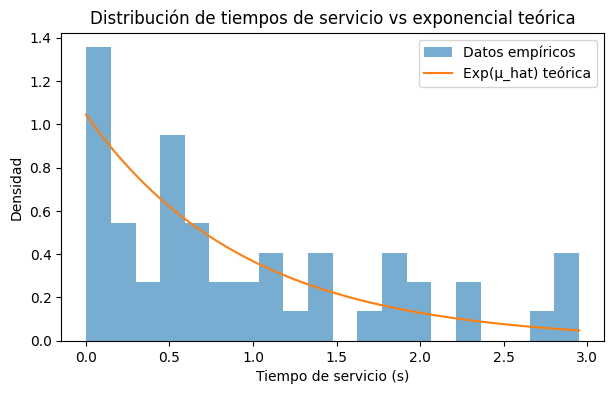

In [12]:
servicios = df_server["tiempo_servicio"].values

plt.figure(figsize=(7,4))
# histograma normalizado (densidad)
plt.hist(servicios, bins=20, density=True, alpha=0.6, label="Datos empíricos")

# Curva de densidad exponencial teórica con μ_hat
x_vals = np.linspace(0, servicios.max(), 200)
pdf_exp = mu_hat * np.exp(-mu_hat * x_vals)
plt.plot(x_vals, pdf_exp, label="Exp(μ_hat) teórica")

plt.xlabel("Tiempo de servicio (s)")
plt.ylabel("Densidad")
plt.title("Distribución de tiempos de servicio vs exponencial teórica")
plt.legend()
plt.show()


# Cálculo de métricas teóricas M/M/1 con λ_hat y μ_hat

In [13]:
if rho_hat < 1:
    Wq_teo = rho_hat / (mu - lambda_hat)
    W_teo  = 1.0 / (mu - lambda_hat)
    Lq_teo = lambda_hat * Wq_teo
    L_teo  = lambda_hat * W_teo
else:
    Wq_teo = W_teo = Lq_teo = L_teo = np.nan
    print("⚠️ ρ_hat ≥ 1 → modelo inestable, fórmulas M/M/1 no aplican bien.")

print(f"Wq_teo ≈ {Wq_teo:.4f} s")
print(f"W_teo  ≈ {W_teo:.4f} s")
print(f"Lq_teo ≈ {Lq_teo:.4f}")
print(f"L_teo  ≈ {L_teo:.4f}")


Wq_teo ≈ 0.5601 s
W_teo  ≈ 1.5164 s
Lq_teo ≈ 0.2163
L_teo  ≈ 0.5856
